In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "tahkeer_data.csv"
all_data = pd.read_csv(data_path)

columns = all_data.columns.tolist()[1:]
columns.remove("smoking")

# Feature engineering
## 1. Remove outliers

In [47]:
columns_to_manage_outliers = {
    "weight(kg)": [40, 110],
    "HDL": [30, 100],
    "triglyceride": [0, 400],
    "fasting blood sugar": [60, 180],
    "Cholesterol": [100, 300],
    "LDL": [20, 250],
    "AST": [0, 60],
    "Gtp": [0, 200],
    "eyesight(left)": [0, 2],
    "waist(cm)": [55, 110],
    "serum creatinine": [0, 2],
    "systolic": [80, 170],
}

for column_name, values in columns_to_manage_outliers.items():
    min_value = values[0]
    max_value = values[1]
    all_data = all_data[(all_data[column_name] >= min_value) & (all_data[column_name] <= max_value)]

In [60]:
def plot_histograms(data, c):
    column_count = len(c)
    row_count = (column_count + 1) // 2
    fig, axs = plt.subplots(row_count, 2, figsize=(15, 5 * row_count))
    
    for i in range(column_count):
        # plt.subplot(column_count, 1, i+1)
        col = c[i]
        sns.histplot(data, x=col, ax=axs[i//2, i%2], hue='smoking', kde=True)
        axs[i//2, i%2].set_title(col)
    
    plt.tight_layout()
    plt.show()

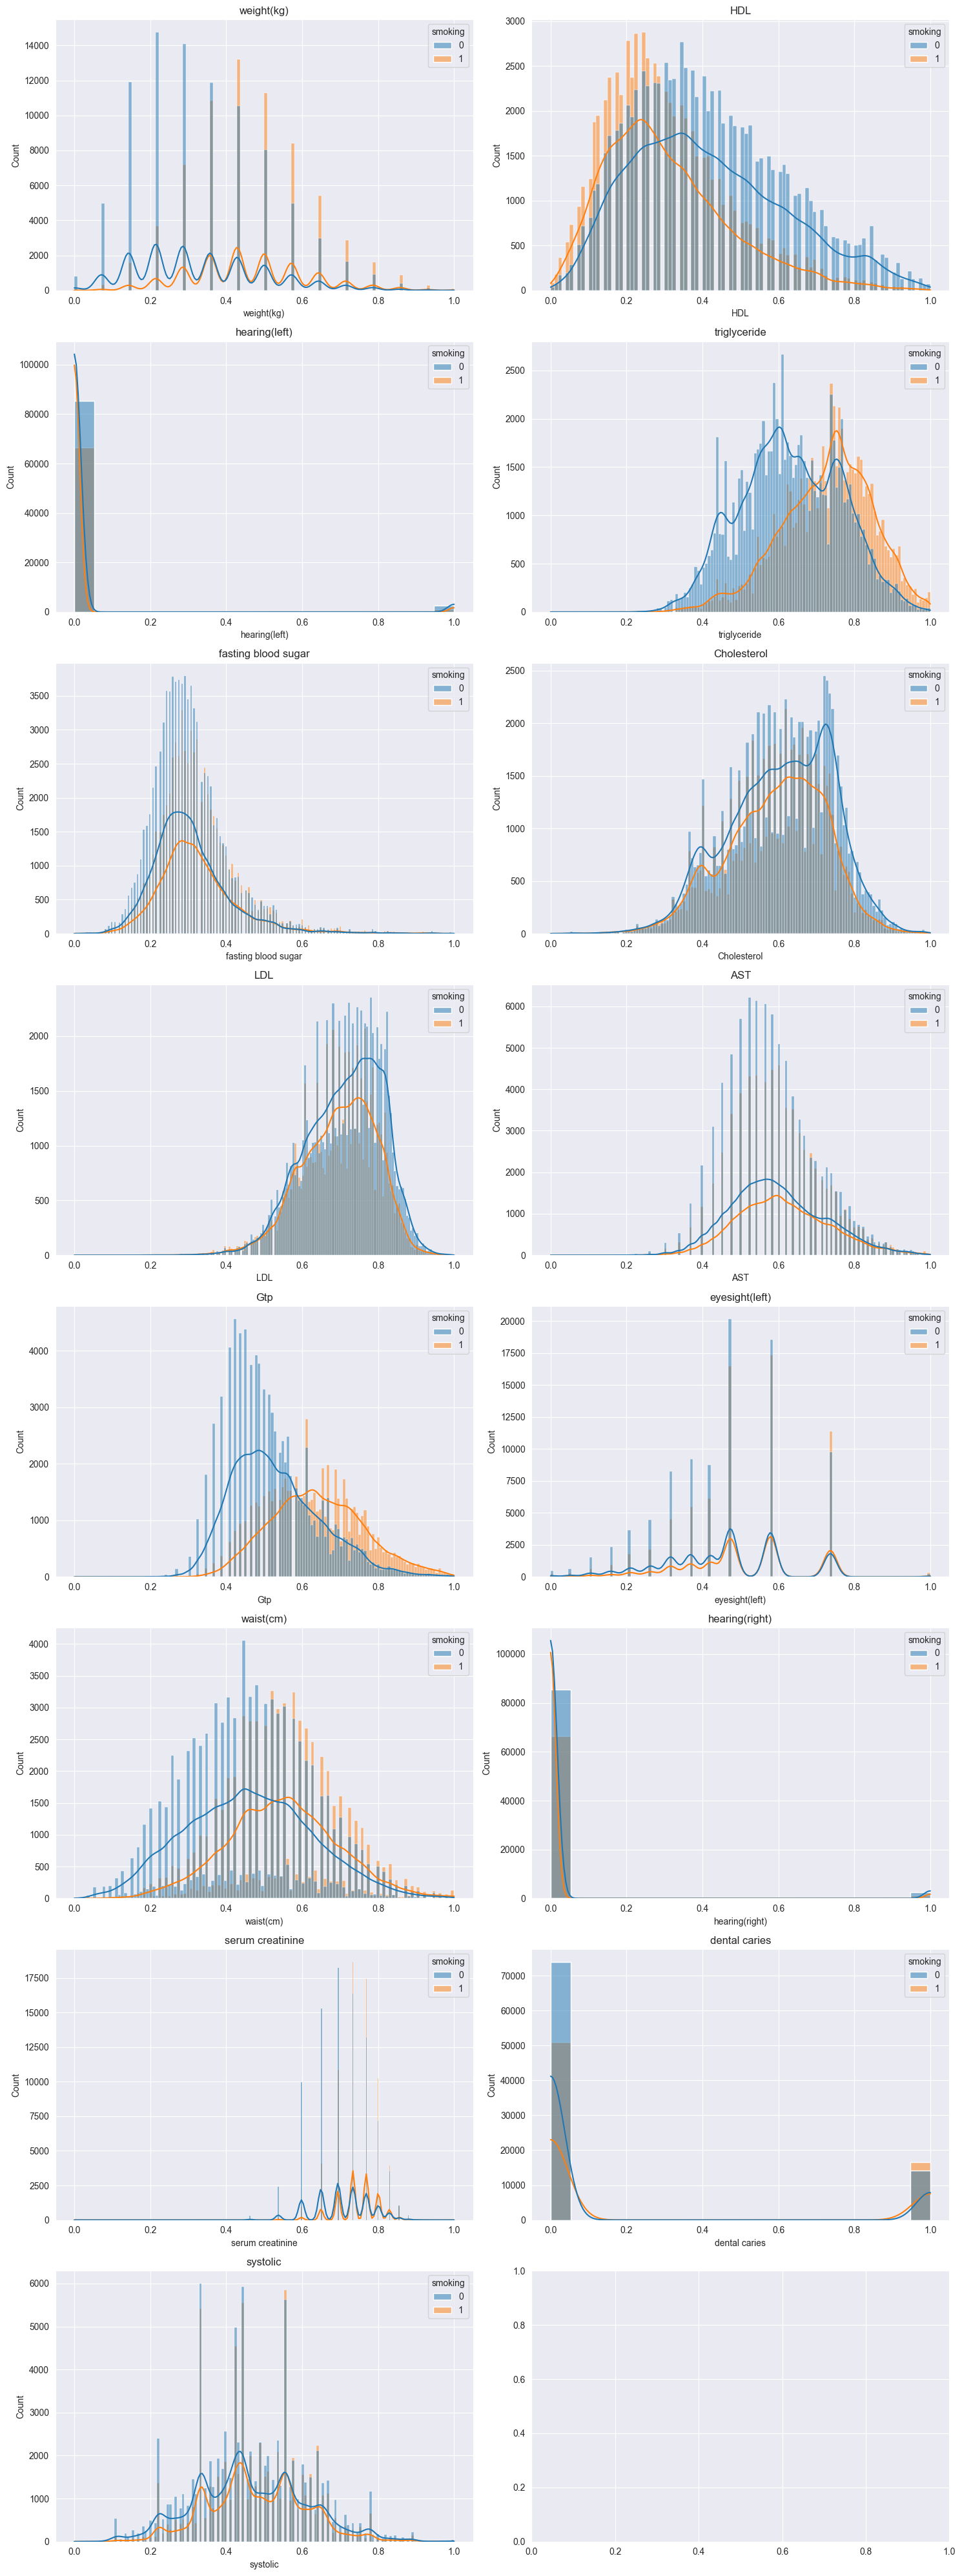

In [61]:
plot_histograms(all_data, columns)

## 2. Apply log to Gtp

In [50]:
logged_columns = ['Gtp', 'triglyceride', 'AST', 'LDL', 'Cholesterol', 'serum creatinine']

for column in logged_columns:
    all_data[column] = np.log(all_data[column])

## 3. Min-Max normalization
We will use min-max normalization to normalize the data to the range [0, 1]
to reduce the effect of large values on the model.

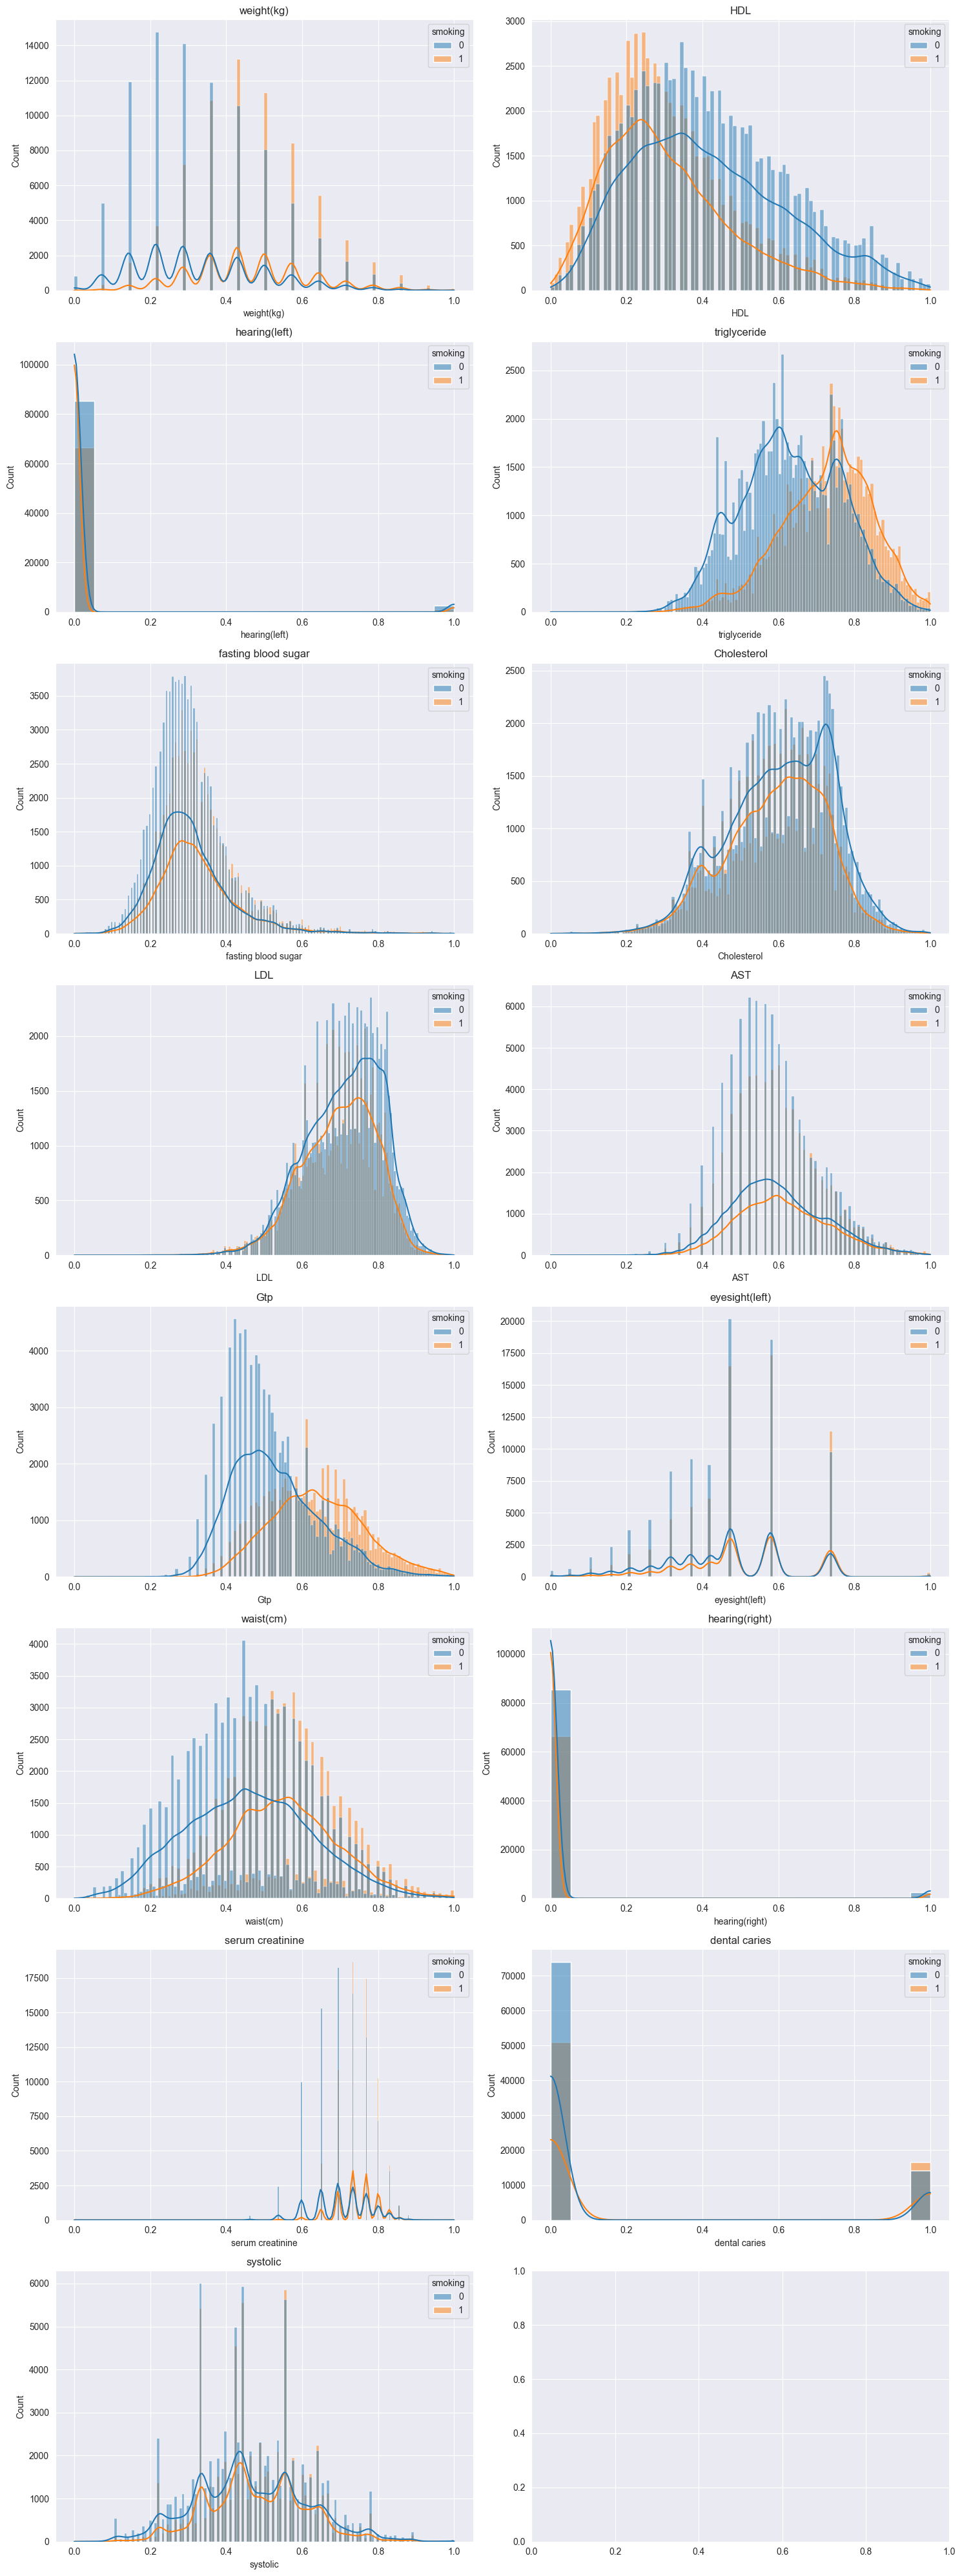

In [62]:
for column in columns:
    min_value = all_data[column].min()
    max_value = all_data[column].max()
    all_data[column] = (all_data[column] - min_value) / (max_value - min_value)

plot_histograms(all_data, columns)

In [66]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'X' contains your features and 'y' contains the target variable
model = RandomForestClassifier(random_state=42)
model.fit(all_data[columns].values, all_data['smoking'].values)

feature_importance = model.feature_importances_
feature_importance = pd.DataFrame({'feature': columns, 'importance': feature_importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [70]:
print(feature_importance)

                feature  importance
8                   Gtp    0.156281
3          triglyceride    0.117477
0            weight(kg)    0.082134
12     serum creatinine    0.080218
10            waist(cm)    0.078363
6                   LDL    0.077363
5           Cholesterol    0.075935
1                   HDL    0.075915
4   fasting blood sugar    0.068829
14             systolic    0.067095
7                   AST    0.063781
9        eyesight(left)    0.041509
13        dental caries    0.009979
11       hearing(right)    0.002577
2         hearing(left)    0.002545


In [68]:
threshold = 0.05
useful_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()

print("Useful features: " + str(useful_features))

Useful features:['Gtp', 'triglyceride', 'weight(kg)', 'serum creatinine', 'waist(cm)', 'LDL', 'Cholesterol', 'HDL', 'fasting blood sugar', 'systolic', 'AST']


In [69]:
all_data = all_data[useful_features + ['smoking']]

all_data.to_csv("tahkeer_data_cleaned.csv", index=False)